## Price Elasticity of Demand

### Problem_Statement /Business Problem

Our client, ABC Electronics is a company that produces and sells a variety of electronics goods, 
including speakers, laptops, and televisions. The company is facing a major challenge in managing 
their inventory. Despite their efforts to reduce costs and increase sales, they have noticed a decline
in sales for a particular category of products**. They believe that the decline in sales is due to a 
change in consumer behaviour, specifically in the way that consumers are responding to changes in price. 
In order to address this issue, ABC Electronics has asked us to perform a data science project on the 
Price Elasticity of Demand for their products.This project will be developed with the stakeholder's 
needs in mind and potentially deliver significant value to sales, marketing, and regulatory managers,
by providing data-driven insights into consumer behaviour and product demand.


### Requirements

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import mode 
import re

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import euclidean_distances


import statsmodels.api as sm  # for ols model

### Data_gathering

In [2]:
df=pd.read_csv('data.csv')    ## 
# df.head()                   

df.shape

(14592, 31)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14592 entries, 0 to 14591
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   14592 non-null  object 
 1   prices.amountMax     14592 non-null  float64
 2   prices.amountMin     14592 non-null  float64
 3   prices.availability  12667 non-null  object 
 4   prices.condition     13189 non-null  object 
 5   prices.currency      14592 non-null  object 
 6   prices.dateSeen      14592 non-null  object 
 7   prices.isSale        14592 non-null  bool   
 8   prices.merchant      13820 non-null  object 
 9   prices.shipping      8793 non-null   object 
 10  prices.sourceURLs    14592 non-null  object 
 11  asins                14592 non-null  object 
 12  brand                14592 non-null  object 
 13  categories           14592 non-null  object 
 14  dateAdded            14592 non-null  object 
 15  dateUpdated          14592 non-null 

In [4]:
null_frame=pd.DataFrame(((df.isna().sum())/df.shape[0])*100,columns=['null_val'])  # calculation null value percentage
null_frame['data_type'] = df.dtypes
null_frame.T

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.currency,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,...,name,primaryCategories,sourceURLs,upc,weight,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
null_val,0.0,0.0,0.0,13.19216,9.614857,0.0,0.0,0.0,5.29057,39.740954,...,0.0,0.0,0.0,0.0,0.0,99.73273,99.876645,99.958882,99.917763,99.958882
data_type,object,float64,float64,object,object,object,object,bool,object,object,...,object,object,object,object,object,object,object,float64,object,object


In [5]:
df.columns
df.describe()

,prices.amountMax,prices.amountMin,Unnamed: 28
count,14592.000000,14592.000000,6.000000e+00
mean,509.578897,487.323215,8.850000e+11
std,1008.512738,967.083200,0.000000e+00
min,1.000000,1.000000,8.850000e+11
25%,79.990000,79.950000,8.850000e+11
50%,195.000000,188.035000,8.850000e+11
75%,499.990000,499.000000,8.850000e+11
max,26871.000000,26871.000000,8.850000e+11


## Data_cleaning

In [6]:
df.corr().tail(1)

,prices.amountMax,prices.amountMin,prices.isSale,Unnamed: 28
Unnamed: 28,NaN,NaN,NaN,NaN


In [7]:
# f1
df['id'].isna().sum()
df['id'].nunique()

1245

In [8]:
# f2
df['prices.amountMax'].value_counts() # no null values
df['prices.amountMin'].value_counts() # no null values


99.99     218
149.99    190
199.99    187
59.99     172
79.99     164
         ... 
99.97       1
59.90       1
38.14       1
41.56       1
77.98       1
Name: prices.amountMin, Length: 4907, dtype: int64

In [9]:
# f-3
df['prices.availability']=np.where(df['prices.availability'].str.contains('Yes|TRUE|In Stock|yes|available'),'yes',
                          np.where(df['prices.availability'].str.contains('No|sold|FALSE|Retired|Discontinued'),'no',
                          np.where(df['prices.availability'].str.contains('Special Order|More on the Way|More Coming Soon'),
                                      'other','other')))
df['prices.availability'].value_counts()

yes      13967
other      539
no          86
Name: prices.availability, dtype: int64

In [10]:
# f-4
df['prices.condition']=np.where(df['prices.condition'].str.contains('New|new'),'new',
                       np.where(df['prices.condition'].str.contains('Refurbished|refurbished'),'refurbished','used'))
                          
df['prices.condition'].value_counts()

df['prices.condition'].unique()

array(['new', 'refurbished', 'used'], dtype=object)

### 5-df['prices.currency']

In [11]:
df['prices.currency'].value_counts()
# df['prices.currency'].isna().sum() no null values


USD    14496
CAD       53
EUR       33
SGD        8
GBP        2
Name: prices.currency, dtype: int64

### 6- df['prices.dateSeen']

Here we don't have impression count or quantity sold but our end goal is to check 
impact of price in quantity. so we need create this feature. dateseen is number of
times product has been seen in that day/week/month etc. Hence lets assume every seen is 1 quantity sold.
Steps - Split the dateseen and count the length of dates that serves as impression
Also, convert date seen into date column so we can utilize its date component

In [12]:
df['prices.dateSeen']      

0        2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...
1                                     2017-12-14T06:00:00Z
2                                     2017-09-08T05:00:00Z
3                                     2017-10-10T05:00:00Z
4                                     2017-08-28T07:00:00Z
                               ...                        
14587                                 2015-09-05T00:00:00Z
14588    2017-10-10T19:00:00Z,2017-09-06T17:00:00Z,2017...
14589                                 2018-03-05T11:00:00Z
14590                                 2016-03-22T00:00:00Z
14591                                 2015-12-05T00:00:00Z
Name: prices.dateSeen, Length: 14592, dtype: object

In [13]:
# we are adding a new feature as df['impression_count'] to see hoe many times it occure in a day
df['quantity_sold']=df['prices.dateSeen'].apply(lambda x : len(x.split(',')))

# converting object data type to datetime 
df['prices.dateSeen']=pd.to_datetime(df['prices.dateSeen'].apply(lambda x : x.split(',')[0]))
df['prices.dateSeen']

0       2017-03-30 06:00:00+00:00
1       2017-12-14 06:00:00+00:00
2       2017-09-08 05:00:00+00:00
3       2017-10-10 05:00:00+00:00
4       2017-08-28 07:00:00+00:00
                   ...           
14587   2015-09-05 00:00:00+00:00
14588   2017-10-10 19:00:00+00:00
14589   2018-03-05 11:00:00+00:00
14590   2016-03-22 00:00:00+00:00
14591   2015-12-05 00:00:00+00:00
Name: prices.dateSeen, Length: 14592, dtype: datetime64[ns, UTC]

In [14]:
# feature enginnering of three column 
df['week_no']      = df['prices.dateSeen'].dt.week
df['month_name']   = df['prices.dateSeen'].dt.strftime('%B')
df['day_name']     = df['prices.dateSeen'].dt.strftime('%A')
df['year']         = df['prices.dateSeen'].dt.year

### 7-df['prices.isSale']

In [15]:
# df['prices.isSale'].unique()
# we noticed some anamolies while we checked isSale column, 
# Analogy is if isSale is true then Actual Price != Discount Price because there would be some discount in sale
#if isSale is False then Actual Price == Discount Price because there won't be any discount in sale

# if max price and min price are equal then there is no discount

In [16]:
df['prices.isSale'] = [str(i).strip() for i in df['prices.isSale']]
df['prices.isSale'].isna().sum()
df['prices.isSale']
df['prices.isSale']= df['prices.isSale'].replace({'False':0,'True':1},)

In [17]:
df['prices.isSale'] = np.where((df['prices.amountMax']==df['prices.amountMin'])& (df['prices.isSale']==1),
                                df['prices.isSale'] == 0,df['prices.isSale'])

df['prices.isSale'] = np.where((df['prices.amountMax']!=df['prices.amountMin'])& (df['prices.isSale']==0),
                                df['prices.isSale'] == 1,df['prices.isSale'])

In [18]:
df['prices.isSale'].value_counts()

0    13491
1     1101
Name: prices.isSale, dtype: int64

### 8df['prices.merchant']

In [19]:
df['prices.merchant'].value_counts()

df['prices.merchant'].fillna(mode(df['prices.merchant'])[0][0],inplace=True)
df['prices.merchant'].isna().sum()
df['prices.merchant'].unique()

df['prices.merchant']=df['prices.merchant'].apply(lambda x : x.split('.com')[0])


In [20]:
df['prices.merchant'].value_counts()
# df[df['prices.merchant'] == 'Bestbuy']

Bestbuy                 5225
bhphotovideo            2744
Walmart                 1105
Amazon                   438
Beach Camera             307
                        ... 
audiowattstore             1
creative-car-audio         1
chenjincheng127986-3       1
firstclasstvs              1
Entrotek - Walmart         1
Name: prices.merchant, Length: 1553, dtype: int64

### 9 - df['prices.shipping']

In [21]:
# around 39 % null values in feature
# df['prices.shipping'].value_counts()
# df['prices.shipping'].unique()
# df['prices.shipping'].isna().sum()

### 10- df['prices.sourceURLs']

In [22]:
# df['prices.sourceURLs'].isna().sum()
# df['prices.sourceURLs'].value_counts()

# df['prices.sourceURLs']=df['prices.sourceURLs'].apply(lambda x: x.split('.')[1])
# df['prices.sourceURLs']

### 11- df['asins']

In [23]:
# df['asins'].unique()
# # df['asins'].value_counts()
# # df['asins'].isna().sum()

### 12 - df['brand']

In [24]:
# df['brand'].value_counts()

### 21 - df['name']

In [25]:
# we will drop this column
# df['name'].value_counts()

### 22 - df['primaryCategories']

In [26]:
# we will drop this column
df['primaryCategories']=df['primaryCategories'].apply(lambda x : x.strip())
df['primaryCategories'].unique()
# df['primaryCategories'].head(50)
df['primaryCategories'].value_counts()

Electronics              14482
Electronics,Furniture       61
Apple CarPlay               27
Intel Celeron               12
Siri Eyes Free               6
Electronics,Media            4
Name: primaryCategories, dtype: int64

### 23 - df['sourceURLs']

In [27]:
# we will drop this column
# df['sourceURLs'].value_counts()

### 25 - df['weight']

In [28]:
# we will drop this column
# df['weight'].value_counts()

In [29]:
null_frame=pd.DataFrame(((df.isna().sum())/df.shape[0])*100,columns=['null_val'])  # calculation null value percentage
null_frame['data_type'] = df.dtypes
null_frame.T

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.currency,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,...,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,quantity_sold,week_no,month_name,day_name,year
null_val,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.740954,...,99.73273,99.876645,99.958882,99.917763,99.958882,0.0,0.0,0.0,0.0,0.0
data_type,object,float64,float64,object,object,object,"datetime64[ns, UTC]",int64,object,object,...,object,object,float64,object,object,int64,int64,object,object,int64


In [30]:
df

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.currency,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,...,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,quantity_sold,week_no,month_name,day_name,year
0,AVphzgbJLJeJML43fA0o,104.99,104.99,yes,new,USD,2017-03-30 06:00:00+00:00,0,Bestbuy,NaN,...,NaN,NaN,NaN,NaN,NaN,4,13,March,Thursday,2017
1,AVpgMuGwLJeJML43KY_c,69.00,64.99,yes,new,USD,2017-12-14 06:00:00+00:00,1,Walmart,Expedited,...,NaN,NaN,NaN,NaN,NaN,1,50,December,Thursday,2017
2,AVpgMuGwLJeJML43KY_c,69.00,69.00,yes,new,USD,2017-09-08 05:00:00+00:00,0,Walmart,Expedited,...,NaN,NaN,NaN,NaN,NaN,1,36,September,Friday,2017
3,AVpgMuGwLJeJML43KY_c,69.99,69.99,yes,new,USD,2017-10-10 05:00:00+00:00,0,Bestbuy,NaN,...,NaN,NaN,NaN,NaN,NaN,1,41,October,Tuesday,2017
4,AVpgMuGwLJeJML43KY_c,66.99,66.99,yes,new,USD,2017-08-28 07:00:00+00:00,0,Bestbuy,NaN,...,NaN,NaN,NaN,NaN,NaN,1,35,August,Monday,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14587,AVpgibRDLJeJML43PTZX,65.99,65.99,yes,new,USD,2015-09-05 00:00:00+00:00,0,Bestbuy,USD 13.81 shipping,...,NaN,NaN,NaN,NaN,NaN,1,36,September,Saturday,2015
14588,AVpgibRDLJeJML43PTZX,58.99,58.99,yes,new,USD,2017-10-10 19:00:00+00:00,0,Bestbuy,NaN,...,NaN,NaN,NaN,NaN,NaN,6,41,October,Tuesday,2017
14589,AVpgibRDLJeJML43PTZX,58.49,58.49,yes,new,USD,2018-03-05 11:00:00+00:00,0,Walmart,Standard,...,NaN,NaN,NaN,NaN,NaN,1,10,March,Monday,2018
14590,AVpgibRDLJeJML43PTZX,77.98,77.98,yes,new,USD,2016-03-22 00:00:00+00:00,0,Bestbuy,NaN,...,NaN,NaN,NaN,NaN,NaN,1,12,March,Tuesday,2016


In [31]:
category_name = pd.read_csv('DatafinitiElectronicsProductsPricingData_Cleaned_dataset.csv',)


df['Category_name'] = category_name['Category_name']


df['Category_name'].fillna(df['Category_name'].mode()[0],inplace=True)

In [32]:
# df.isna().sum()
df1 = df.copy()

In [33]:

df1.rename(columns={ 'prices.amountMax':'Actual_price',
                        'prices.amountMin':'Discount_price',
                        'prices.availability':'Product_availability',
                        'prices.condition':'Condition',
                        'prices.currency':'Currency',
                        'prices.isSale':'isSale',
                        'prices.merchant':'merchant',
                        'prices.dateSeen':'Date',
                        'categories':'Description'
                        },inplace=True)

In [34]:
#Select important features that we are using ahead.
sub_df = df1[['id','Actual_price','Discount_price','Product_availability','Condition',
             'Currency','Date','isSale','merchant','brand','Description',
             'Category_name','primaryCategories','name','quantity_sold','week_no','month_name','day_name','year']]

sub_df['discount_percentage'] = ((sub_df['Actual_price']-sub_df['Discount_price'])/(sub_df['Actual_price']))*100

sub_df['total_sale'] = (sub_df['quantity_sold'] * sub_df['Discount_price'])
sub_df.sort_index(inplace=True)

In [35]:
sub_df.columns

Index(['id', 'Actual_price', 'Discount_price', 'Product_availability',
       'Condition', 'Currency', 'Date', 'isSale', 'merchant', 'brand',
       'Description', 'Category_name', 'primaryCategories', 'name',
       'quantity_sold', 'week_no', 'month_name', 'day_name', 'year',
       'discount_percentage', 'total_sale'],
      dtype='object')

## Exploratory Data Analysis

the aim of EDA is to find underlying patterns within the data, detect outliers and test assumptions with
the final aim of finding a model that fits the data well.

Insight - from pair plot we can see thet
1- linear relation bet actual price and discount price
2-

In [36]:
# sns.pairplot(sub_df) #

<AxesSubplot: >

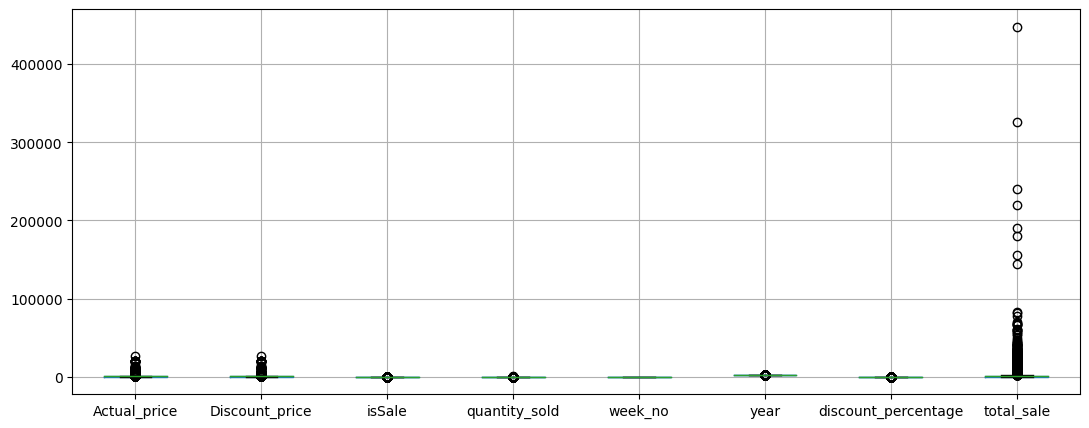

In [37]:
# detection of Outliers
plt.figure(figsize=(13,5))
sub_df.boxplot()

### Bivariate_Analysis

[]

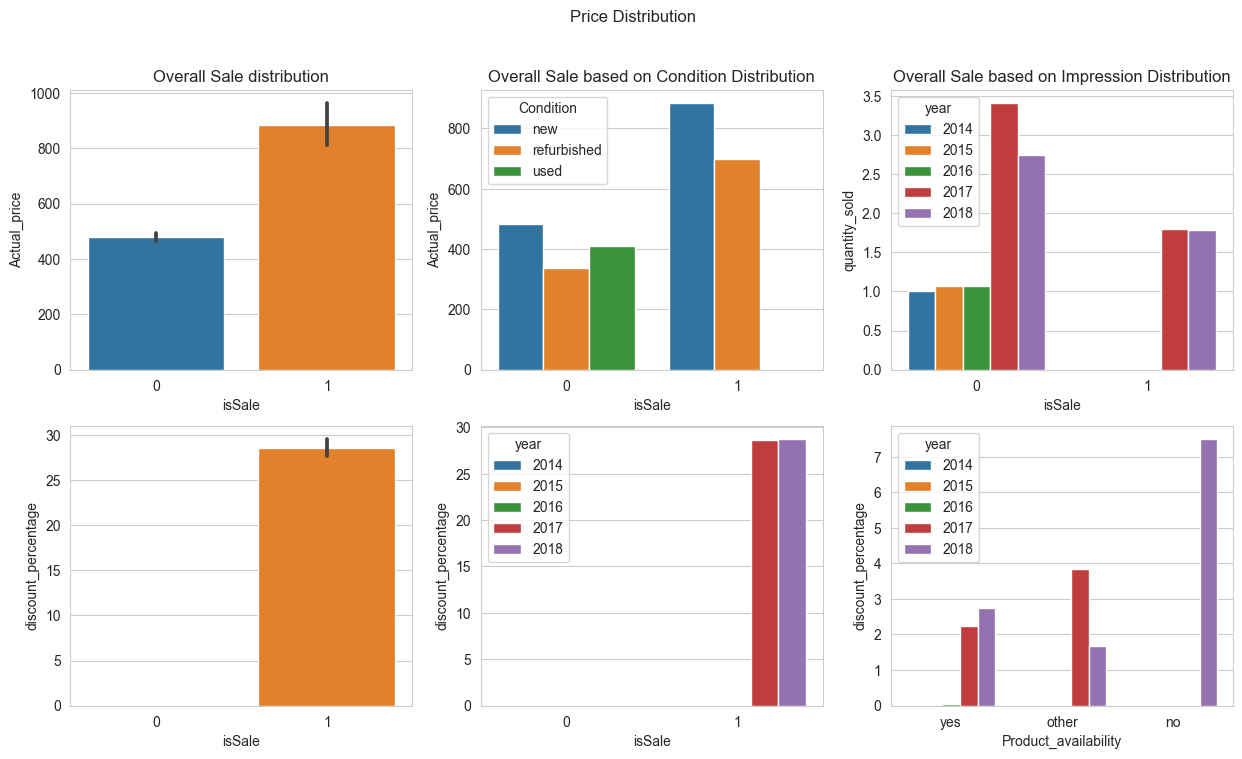

In [38]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(15, 8))
fig.suptitle('Price Distribution')
axes[0,0].set_title('Overall Sale distribution')
axes[0,1].set_title('Overall Sale based on Condition Distribution')
axes[0,2].set_title('Overall Sale based on Impression Distribution')


sns.barplot(ax=axes[0,0],y=sub_df['Actual_price'],x=sub_df['isSale'])
plt.plot()
# insight >> actual price mean 500 on this price the plot show with dis and without discount sale

# sns.set_style("whitegrid")
ax =sns.barplot(ax=axes[0,1],y=sub_df['Actual_price'],x=sub_df['isSale'],hue=sub_df['Condition'],errorbar=None)
plt.plot()  
# insight >> new pro actual price mean 500 on sale dist
#         >> refub pro actual price mean 500 on sale dist
#         >> used pro actual price mean 500 on sale dist
# when dis is applied new prod sale increses

ax =sns.barplot(ax=axes[0,2],y=sub_df['quantity_sold'],x=sub_df['isSale'],errorbar=None,hue=sub_df['year'])
plt.plot()


ax=sns.barplot(ax=axes[1,0],y=sub_df['discount_percentage'],x=sub_df['isSale'])
plt.plot()


ax =sns.barplot(ax=axes[1,1],y=sub_df['discount_percentage'],x=sub_df['isSale'],hue=sub_df['year'],errorbar=None)
plt.plot()


ax =sns.barplot(ax=axes[1,2],y=sub_df['discount_percentage'],x=sub_df['Product_availability'],errorbar=None,hue=sub_df['year'])
plt.plot()

[]

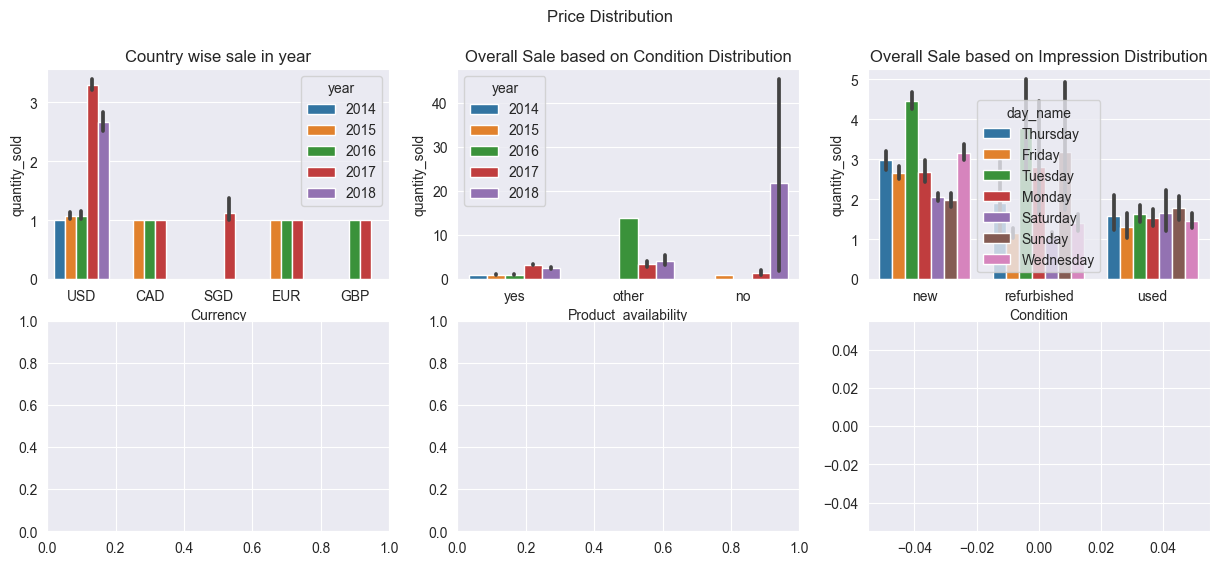

In [39]:
sns.set_style("darkgrid")

fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(15, 6))
fig.suptitle('Price Distribution')
axes[0,0].set_title('Country wise sale in year')
axes[0,1].set_title('Overall Sale based on Condition Distribution')
axes[0,2].set_title('Overall Sale based on Impression Distribution')


sns.barplot(ax=axes[0,0],x=sub_df['Currency'],y=sub_df['quantity_sold'],hue=sub_df['year'])
plt.plot()
# insight >> 1n 2018 and 17 having more quantity sold by usd


ax =sns.barplot(ax=axes[0,1],y=sub_df['quantity_sold'],x=sub_df['Product_availability'],hue=sub_df['year'])
plt.plot()


ax =sns.barplot(ax=axes[0,2],y=sub_df['quantity_sold'],x=sub_df['Condition'],hue=sub_df['day_name'])
plt.plot()



# ax=sns.barplot(ax=axes[1,0],y=sub_df[''],x=sub_df['Product_availability'])
# plt.plot()


# ax =sns.barplot(ax=axes[1,1],y=sub_df['Discount_price'],x=sub_df['isSale'],hue=sub_df['Condition'])
# plt.plot()


# ax =sns.barplot(ax=axes[1,2],y=sub_df['quantity_sold'],x=df1['isSale'])
# plt.plot()

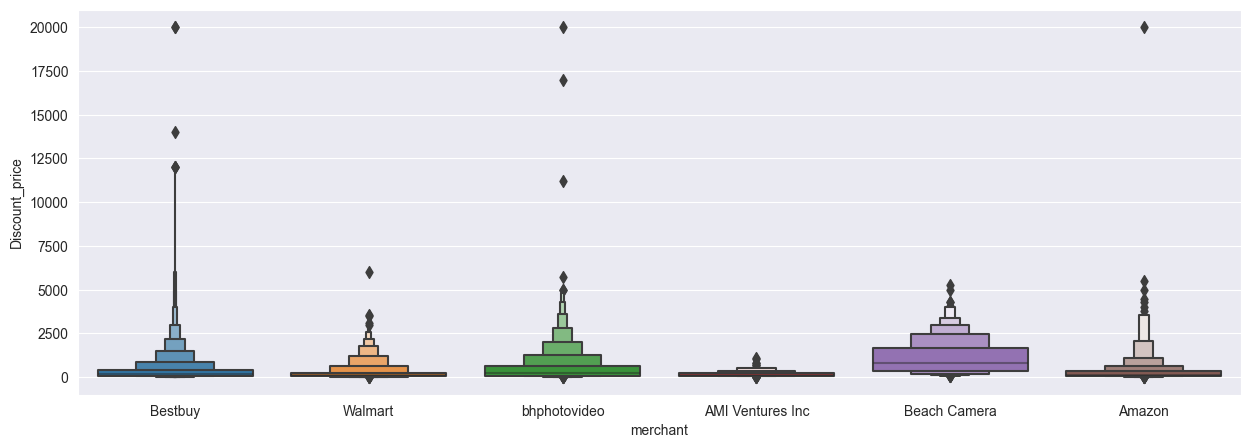

In [40]:
sel_mer=sub_df.loc[sub_df.merchant.isin(sub_df['merchant'].value_counts()[0:6].index)]
plt.figure(figsize=(15,5))
ax=sns.boxenplot(x=sel_mer['merchant'],y=sel_mer['Discount_price'],)

In [41]:
plt.figure(figsize=(15,8))
ax=sns.barplot(ax=axes[1,0],x=sel_mer['Condition'],y=sel_mer['quantity_sold'],hue=sel_mer['day_name'],errorbar=None)

<Figure size 1500x800 with 0 Axes>

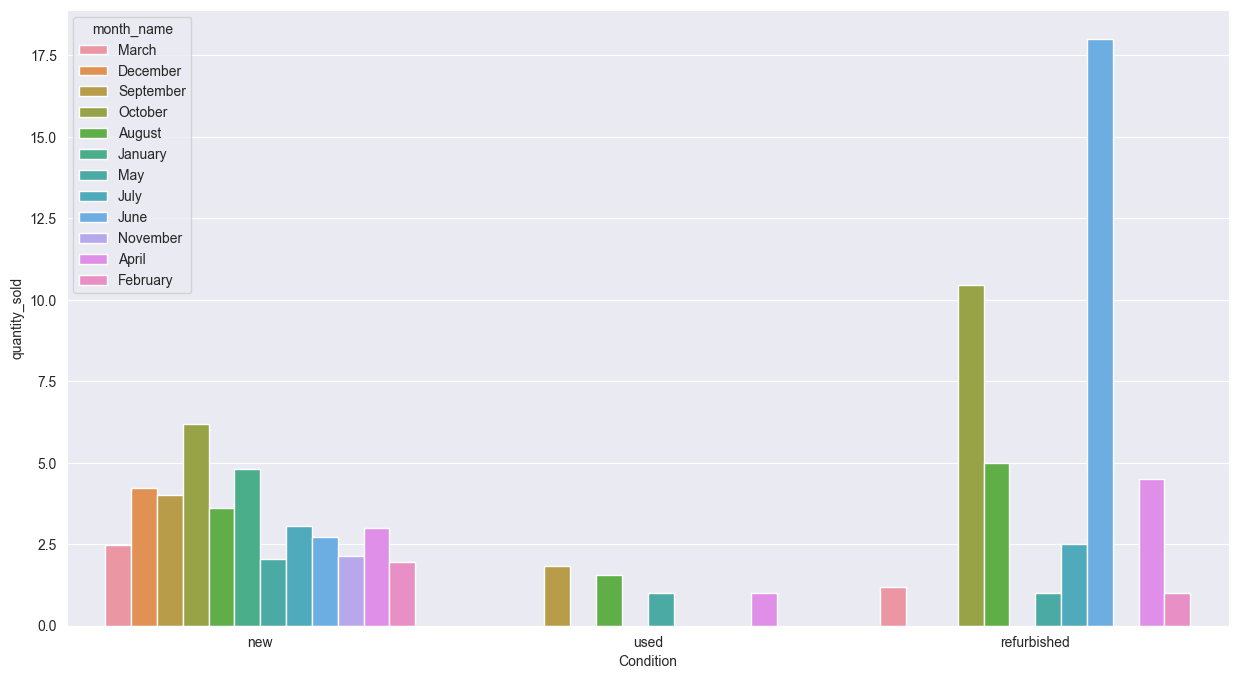

In [42]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x=sel_mer['Condition'],y=sel_mer['quantity_sold'],hue=sel_mer['month_name'],errorbar=None)

## Univariate_analysis

In [43]:
def uni_analysis(s):
    print(s.describe())
    fig,axs=plt.subplots(ncols=2,figsize=(10,5))
    sns.distplot(s,ax=axs[0],color='red')
    sns.boxenplot(s,ax=axs[1],color='green')
    
    

count    14592.000000
mean       509.578897
std       1008.512738
min          1.000000
25%         79.990000
50%        195.000000
75%        499.990000
max      26871.000000
Name: Actual_price, dtype: float64


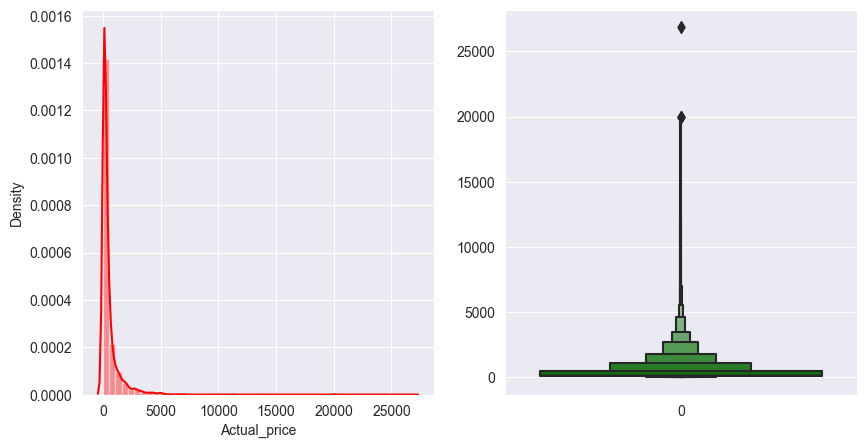

In [44]:
d1=sub_df['Actual_price']
uni_analysis(d1)

count    14592.000000
mean       487.323215
std        967.083200
min          1.000000
25%         79.950000
50%        188.035000
75%        499.000000
max      26871.000000
Name: Discount_price, dtype: float64


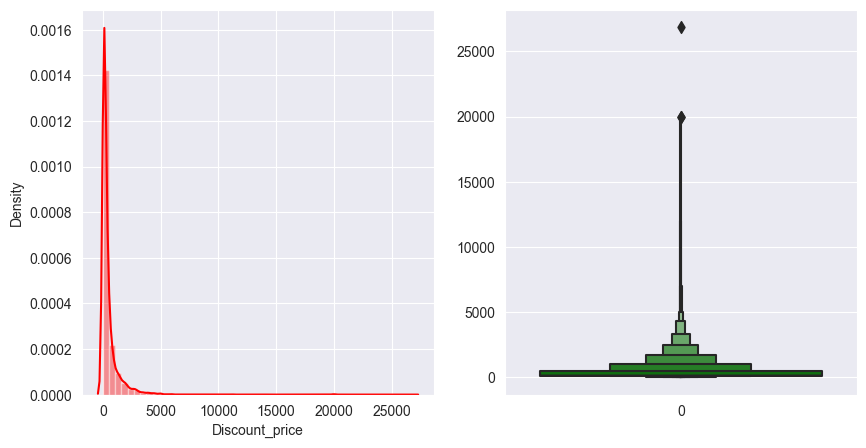

In [45]:
d2=sub_df['Discount_price']
uni_analysis(d2)

count    14592.000000
mean         2.963130
std          4.849232
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        198.000000
Name: quantity_sold, dtype: float64


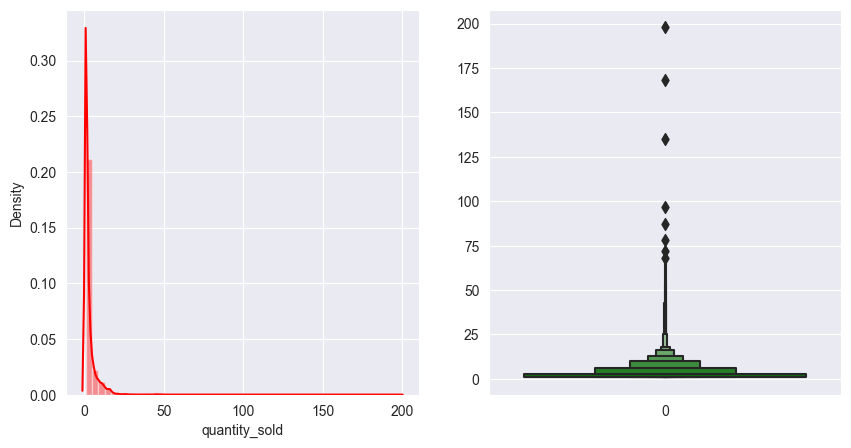

In [46]:
d3=sub_df['quantity_sold']
uni_analysis(d3)

<AxesSubplot: xlabel='year', ylabel='quantity_sold'>

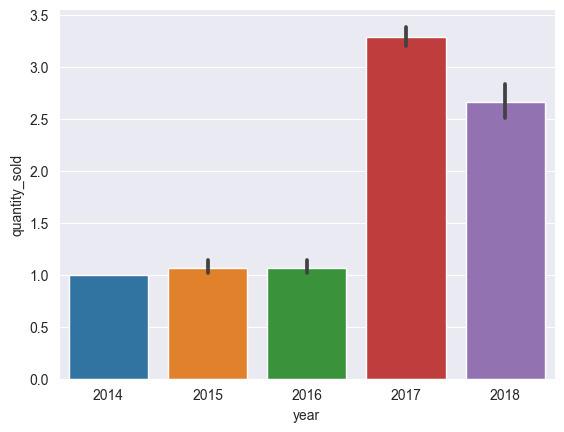

In [47]:
sns.barplot(y=sub_df['quantity_sold'],x=sub_df['year'],)

<AxesSubplot: >

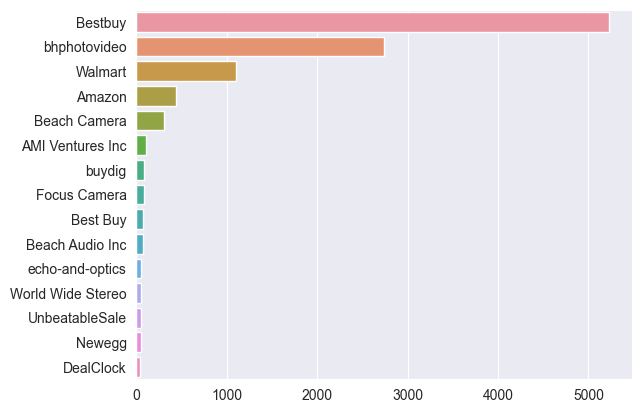

In [48]:
# in dataset for Bestbuy merchant having more value counts

sns.barplot( x = sub_df['merchant'].value_counts().values[:15],y = sub_df['merchant'].value_counts().index[:15])

In [49]:
sub_df.corr().tail(1)

,Actual_price,Discount_price,isSale,quantity_sold,week_no,year,discount_percentage,total_sale
total_sale,0.511804,0.526486,-0.01483,0.331459,-0.011863,0.038701,-0.008271,1.0


when we see the correation we  continuous vs continuous var

In [50]:
# df1.to_excel('clean.xlsx',sheet_name='data')

## Feature_Engineering

In [51]:
# sub_df.info()
# converting object data type to int
sub_df['Condition'] = np.where(sub_df['Condition'] == 'new',1,
                      np.where(sub_df['Condition'] == 'refurbished',2,
                      np.where(sub_df['Condition'] == 'used',0,0)))


sub_df['Product_availability'] = np.where(sub_df['Product_availability'] == 'yes',1,
                                 np.where(sub_df['Product_availability'] == 'no',0,
                                 np.where(sub_df['Product_availability'] == 'other',2,2)))

In [52]:
sub_df

,id,Actual_price,Discount_price,Product_availability,Condition,Currency,Date,isSale,merchant,brand,...,Category_name,primaryCategories,name,quantity_sold,week_no,month_name,day_name,year,discount_percentage,total_sale
0,AVphzgbJLJeJML43fA0o,104.99,104.99,1,1,USD,2017-03-30 06:00:00+00:00,0,Bestbuy,Sanus,...,"mount, tv, stand",Electronics,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,4,13,March,Thursday,2017,0.000000,419.96
1,AVpgMuGwLJeJML43KY_c,69.00,64.99,1,1,USD,2017-12-14 06:00:00+00:00,1,Walmart,Boytone,...,"speaker, audio",Electronics,Boytone - 2500W 2.1-Ch. Home Theater System - ...,1,50,December,Thursday,2017,5.811594,64.99
2,AVpgMuGwLJeJML43KY_c,69.00,69.00,1,1,USD,2017-09-08 05:00:00+00:00,0,Walmart,Boytone,...,"speaker, audio",Electronics,Boytone - 2500W 2.1-Ch. Home Theater System - ...,1,36,September,Friday,2017,0.000000,69.00
3,AVpgMuGwLJeJML43KY_c,69.99,69.99,1,1,USD,2017-10-10 05:00:00+00:00,0,Bestbuy,Boytone,...,"speaker, audio",Electronics,Boytone - 2500W 2.1-Ch. Home Theater System - ...,1,41,October,Tuesday,2017,0.000000,69.99
4,AVpgMuGwLJeJML43KY_c,66.99,66.99,1,1,USD,2017-08-28 07:00:00+00:00,0,Bestbuy,Boytone,...,"speaker, audio",Electronics,Boytone - 2500W 2.1-Ch. Home Theater System - ...,1,35,August,Monday,2017,0.000000,66.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14587,AVpgibRDLJeJML43PTZX,65.99,65.99,1,1,USD,2015-09-05 00:00:00+00:00,0,Bestbuy,naxa,...,"drive, storage, hard",Electronics,naxa - 2.1-Channel Soundbar with 50-Watt Digit...,1,36,September,Saturday,2015,0.000000,65.99
14588,AVpgibRDLJeJML43PTZX,58.99,58.99,1,1,USD,2017-10-10 19:00:00+00:00,0,Bestbuy,naxa,...,"drive, storage, hard",Electronics,naxa - 2.1-Channel Soundbar with 50-Watt Digit...,6,41,October,Tuesday,2017,0.000000,353.94
14589,AVpgibRDLJeJML43PTZX,58.49,58.49,1,1,USD,2018-03-05 11:00:00+00:00,0,Walmart,naxa,...,"drive, storage, hard",Electronics,naxa - 2.1-Channel Soundbar with 50-Watt Digit...,1,10,March,Monday,2018,0.000000,58.49
14590,AVpgibRDLJeJML43PTZX,77.98,77.98,1,1,USD,2016-03-22 00:00:00+00:00,0,Bestbuy,naxa,...,"drive, storage, hard",Electronics,naxa - 2.1-Channel Soundbar with 50-Watt Digit...,1,12,March,Tuesday,2016,0.000000,77.98


## Feature_selection

For selection of feature we will first use some Filter methods to check 
relationship bet ind vars.

In [53]:
from sklearn.feature_selection import chi2,_univariate_selection,mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

### 1- corr -filter method

<AxesSubplot: >

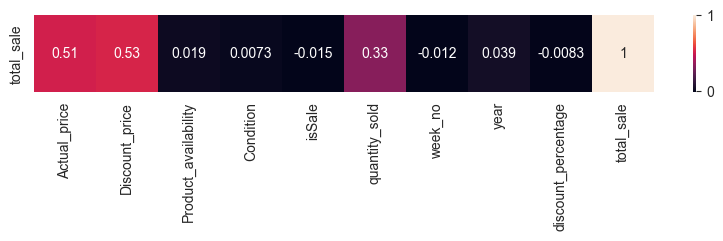

In [54]:
# by seen the corr of features with pearson coeff can see relation bet actual price
# discounted price will cosider for feature selection

plt.figure(figsize=(10,1))
sns.heatmap(sub_df.corr().tail(1),annot=True)

<AxesSubplot: >

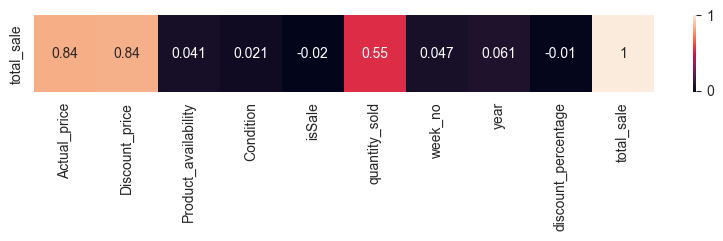

In [55]:
# by seen the corr of features with pearson coeff can see relation bet actual price
# discounted price will cosider for feature selection

plt.figure(figsize=(10,1))
sns.heatmap(sub_df.corr(method='spearman').tail(1),annot=True)

<AxesSubplot: >

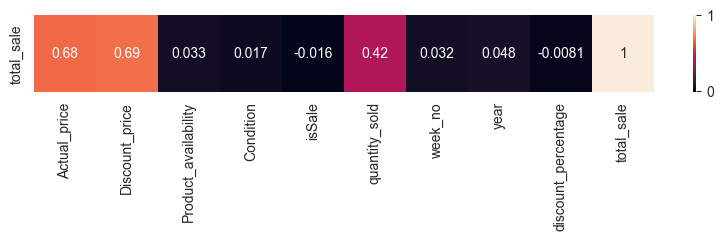

In [56]:
plt.figure(figsize=(10,1))
sns.heatmap(sub_df.corr(method='kendall').tail(1),annot=True)

### 2- mutual information gain -filter method

In [57]:
from sklearn.feature_selection import mutual_info_regression

we can see that the numerical features are only 'Actual_price','Discount_price','discount_percentage','Product_availability','Condition',
'isSale','discount_percentage','year','week_no'

we will check mutual info gain for continuous values


In [58]:
X=sub_df[['Actual_price','Discount_price','Product_availability','Condition',
        'isSale','discount_percentage','year','week_no','quantity_sold']]
Y=sub_df['quantity_sold']


<AxesSubplot: >

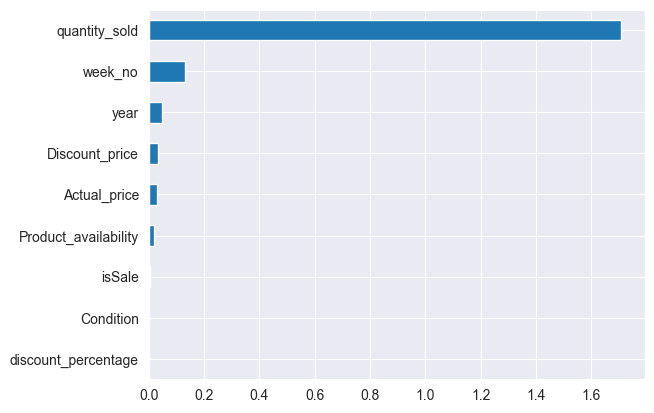

In [59]:
arr1 = mutual_info_regression(X,Y,random_state=11)  # plt.pie(s1,labels=x.columns,autopct='%f',)
s1 = pd.Series(arr1,index=X.columns)

s1.sort_values().plot(kind = 'barh')

In [60]:
# the above graph shows thar the featues Actual price and Discount price having higher importance

### 3- mean abs diff -filter method

Absolute Diff from Mean Values of independent var

<AxesSubplot: >

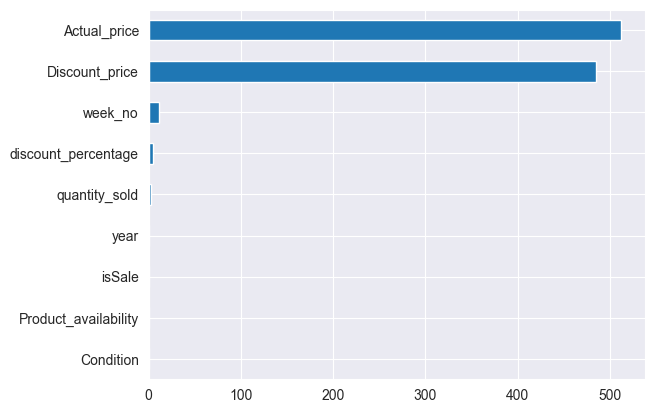

In [61]:
mean_abs_diff = np.sum(np.abs(X - np.mean(X, axis = 0)), axis = 0)/X.shape[0]

s6 = pd.Series(mean_abs_diff, index=X.columns)
s6.sort_values().plot(kind='barh')

### 4- Missing value ratio

the missing values shows that the columns having large no of null values so can drop it

<AxesSubplot: >

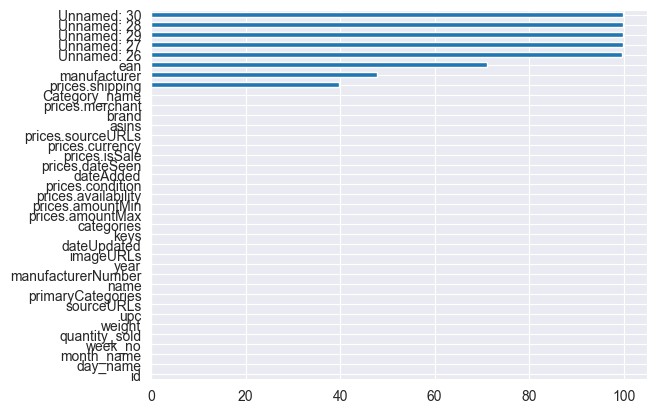

In [62]:
s4 =pd.Series((df.isna().sum() / len(sub_df)) *100,index=df.columns)
s4.sort_values().plot(kind = 'barh')

In [63]:
for i in range(len(df.columns)):
    if s4[i] >=30:
        print(df.columns[i],' >>having null values percentage >>',s4[i],)
    

prices.shipping  >>having null values percentage >> 39.740953947368425
ean  >>having null values percentage >> 71.16228070175438
manufacturer  >>having null values percentage >> 47.79331140350877
Unnamed: 26  >>having null values percentage >> 99.7327302631579
Unnamed: 27  >>having null values percentage >> 99.8766447368421
Unnamed: 28  >>having null values percentage >> 99.95888157894737
Unnamed: 29  >>having null values percentage >> 99.91776315789474
Unnamed: 30  >>having null values percentage >> 99.95888157894737


### 5 - Variance threshold method

Works only with numerical features
Looks for variability in the features

Higher variance may contain more useful information
remove numerical features with low variance

In [64]:
from sklearn.feature_selection import VarianceThreshold

vtm = VarianceThreshold(threshold=0.3)
vtm.fit(X)
vtm.get_support()

array([ True,  True, False, False, False,  True,  True,  True,  True])

In [65]:
## we can select this features for model trainig
X.columns[vtm.get_support()]

Index(['Actual_price', 'Discount_price', 'discount_percentage', 'year',
       'week_no', 'quantity_sold'],
      dtype='object')

### 6 - variance_inflation_factor

<AxesSubplot: >

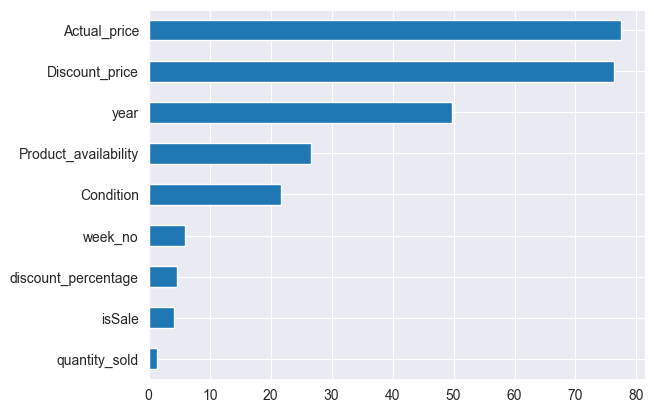

In [66]:
vif_list = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X.values, i)
    vif_list.append(vif)
    
s4 = pd.Series(vif_list, index=X.columns)
s4.sort_values().plot(kind = 'barh')

### 7 - Annova test

In [67]:
from sklearn.feature_selection import f_classif

# Null Hypothesis (H0) >> Two Var are independent 
# Alternate Hypothesis(Ha/H1) >> Two Var are Dependent

# p_val >= 0.05 >> H0 is True
# p_val < 0.05  >> Ha is True

In [68]:
f_val, p_val = f_classif(X, Y)

anova_df = pd.DataFrame({'Features': X.columns, 
                        'f_val': f_val, 'P-Values': np.around(p_val,6)})
anova_df.sort_values('P-Values')

,Features,f_val,P-Values
0,Actual_price,4.027036,0.000000
1,Discount_price,4.324668,0.000000
2,Product_availability,3.637610,0.000000
4,isSale,2.401815,0.000000
6,year,2.896239,0.000000
7,week_no,5.102156,0.000000
8,quantity_sold,inf,0.000000
5,discount_percentage,1.857519,0.000122
3,Condition,0.881862,0.719281


<AxesSubplot: >

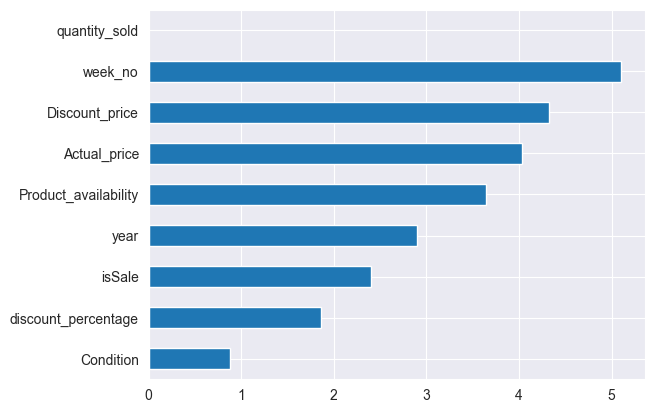

In [69]:
s5 = pd.Series(f_val, index = X.columns)
s5.sort_values().plot(kind = 'barh')

from all above feature selection techniques we conclude that >.

the most important feature for model building are 
1-  Actual_price
2 - Discount_price
3 - discount_percentage
4 - Product_availability
5 - isSale
6 - Condition
7 - quantity_sold

 we will consider this features for model trainig

In [70]:
sub_df.head().T

,0,1,2,3,4
id,AVphzgbJLJeJML43fA0o,AVpgMuGwLJeJML43KY_c,AVpgMuGwLJeJML43KY_c,AVpgMuGwLJeJML43KY_c,AVpgMuGwLJeJML43KY_c
Actual_price,104.99,69.0,69.0,69.99,66.99
Discount_price,104.99,64.99,69.0,69.99,66.99
Product_availability,1,1,1,1,1
Condition,1,1,1,1,1
Currency,USD,USD,USD,USD,USD
Date,2017-03-30 06:00:00+00:00,2017-12-14 06:00:00+00:00,2017-09-08 05:00:00+00:00,2017-10-10 05:00:00+00:00,2017-08-28 07:00:00+00:00
isSale,0,1,0,0,0
merchant,Bestbuy,Walmart,Walmart,Bestbuy,Bestbuy
brand,Sanus,Boytone,Boytone,Boytone,Boytone


## Model_training

In [71]:
sub_df2 = sub_df.groupby(by=['name','week_no']).agg({'Discount_price':'mean','quantity_sold':'sum'}).reset_index()
sub_df2

,name,week_no,Discount_price,quantity_sold
0,1080p Day/Night PTZ Speed Dome Camera with 5 t...,18,459.00,12
1,1080p Day/Night PTZ Speed Dome Camera with 5 t...,35,478.99,6
2,1080p Day/Night PTZ Speed Dome Camera with 5 t...,41,493.99,1
3,1080p Day/Night PTZ Speed Dome Camera with 5 t...,49,369.00,2
4,10TB G-DRIVE with Thunderbolt,2,549.95,11
...,...,...,...,...
10141,naxa - 2.1-Channel Soundbar with 50-Watt Digit...,50,58.99,1
10142,sub6 100W 6 Active Subwoofer (Matte Gray),35,189.99,7
10143,sub6 100W 6 Active Subwoofer (Matte Gray),41,239.99,18
10144,sub6 100W 6 Active Subwoofer (Matte Gray),42,239.99,2


In [72]:
# Converting week level data Price change for all the different products
x_pivot=sub_df2.pivot(index='week_no', columns='name',values='Discount_price')
x_val = pd.DataFrame(x_pivot.to_records())
x_val.fillna(method='ffill',inplace=True)
x_val.fillna(method='bfill',inplace=True)

In [73]:
# Impute using forward fill, here we are assuming that if any week is missing price
# then its price does not get change in coming weeks

In [74]:
y_pivot = sub_df2.pivot(index='week_no',columns='name',values='quantity_sold')
y_val = pd.DataFrame(y_pivot.to_records())
y_val.fillna(method='ffill',inplace=True)
y_val.fillna(method='bfill',inplace=True)

We have a lot of product in the list and for each one we need to create a separate model
with respect to their price and quantity sold

Price elasticity = Change in Quanity sold / Change in the Price

## Ordinary Least-Squares (OLS) Model

In [75]:
import statsmodels.api as sm

Ordinary least-squares (OLS) models assume that the analysis is fitting a model of a relationship between one or more explanatory variables and a continuous or at least interval outcome variable that minimizes the sum of square errors, where an error is the difference between the actual and the predicted value of the outcome variable. The most common analytical method that utilizes OLS models is linear regression (with a single or multiple predictor variables).

In [76]:
final_df = pd.DataFrame()
for col_name in x_val.columns[1:]:
    
    dict1 = { 'name' : [],
              'Price_elasticity' : [],
              'price_mean'  : [],
              'quantity_mean': [],
              'intercept': [],
              'slope' :[],
              'coefficient_val' : [],
              'rscore' : []
             }
    
    t_df = pd.DataFrame()
    t_df['x'] = x_val[col_name]
    t_df['y'] = y_val[col_name]
    t_df.dropna(inplace=True)
    
    x = t_df['x']
    y = t_df['y']
    
    const = sm.add_constant(x)
    ols_mod = sm.OLS(y,const)
    
    result = ols_mod.fit()
    
    #choose only those whose P-value is less than 5% errornous
    
    if result.f_pvalue < 0.05:
        rscore = result.rsquared
        coefficient_pvalue = result.f_pvalue
        
        try:
            intercept,slope = result.params
        except:
            slope = result.params
            
        mean_price = np.mean(x)
        mean_quantity = np.mean(y)
        
        try:
            tintercept, t_score = result.tvalues
        except:
            pass
        
        price_elasticity = (slope)*(mean_price/mean_quantity)
    
    
        dict1['name'].append(col_name)           
        dict1['Price_elasticity'].append(price_elasticity) 
        dict1['price_mean'].append(mean_price)
        dict1['quantity_mean'].append(mean_quantity)
        dict1['intercept'].append(tintercept)
        dict1['slope'].append(slope)
        dict1['coefficient_val'].append(coefficient_pvalue)
        dict1['rscore'].append(rscore)
        final_df =  pd.concat([final_df,pd.DataFrame.from_dict(dict1)],axis=0,ignore_index=True)
        
 


In [78]:
t_arr = np.array([1,'10TB G-DRIVE with Thunderbolt',549.95],ndmin=2)


In [79]:
final_df

,name,Price_elasticity,price_mean,quantity_mean,intercept,slope,coefficient_val,rscore
0,"12 MacBook (Mid 2017, Silver)",-10.463544,1246.636415,4.207547,4.007904e+00,-0.035316,5.989152e-04,0.208003
1,12.3 32GB Multi-Touch 2-in-1 Chromebook Plus,-2.618319,428.410472,2.886792,2.777760e+00,-0.017643,4.849166e-02,0.074182
2,120 Bulb LED Video Light (Daylight),1.256761,63.348868,2.792453,-4.016809e+00,0.055399,4.076135e-26,0.890154
3,128GB iPod touch (Gold) (6th Generation),3.871969,329.857736,4.245283,-3.709577e+00,0.049832,6.280693e-06,0.332236
4,"15.4 MacBook Pro with Touch Bar (Late 2016, Si...",0.953706,2169.467736,4.150943,1.184539e-01,0.001825,1.433452e-02,0.111948
...,...,...,...,...,...,...,...,...
663,iSimple ISBC01 BluClik Bluetooth Remote Contro...,-3.091793,25.380755,2.188679,1.533513e+01,-0.266617,4.653832e-16,0.728625
664,inactive,5.508247,33.708491,5.094340,-4.931052e+00,0.832457,1.792066e-07,0.416812
665,kenwood pkg-mr362bt marine cd receiver with bl...,-8.647829,195.413208,2.377358,1.753563e+15,-0.105208,0.000000e+00,1.000000
666,mophie powerstation Plus Mini External Battery...,6.908507,54.357547,6.037736,-6.955892e+00,0.767359,7.546456e-11,0.567612


In [231]:
final_df.to_excel('final_df_ols.xlsx')

In [224]:
x_val.columns[1]

'1080p Day/Night PTZ Speed Dome Camera with 5 to 61mm Auto Focus Lens'

In [226]:
y_val.columns[1]

'1080p Day/Night PTZ Speed Dome Camera with 5 to 61mm Auto Focus Lens'

### Lineaar_reg_model

In [232]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [234]:
final_df = pd.DataFrame()
for col_name in x_val.columns[1:]:
    
    dict1 = { 'name' : [],
              'Price_elasticity' : [],
              'price_mean'  : [],
              'quantity_mean': [],
              'intercept': [],
              'slope' :[],
              'coefficient_val' : [],
              'rscore' : []
             }
    
    t_df = pd.DataFrame()
    t_df['x'] = x_val[col_name]
    t_df['y'] = y_val[col_name]
    t_df.dropna(inplace=True)
    
    x = t_df['x']
    y = t_df['y']
    
    Lin_model = LinearRegression()
    
    result = Lin_model.fit([x],[y])
    
    #choose only those whose P-value is less than 5% errornous
    
    if result.f_pvalue < 0.05:
        rscore = result.rsquared
        coefficient_pvalue = result.f_pvalue
        
        try:
            intercept,slope = result.params
        except:
            slope = result.params
            
        mean_price = np.mean(x)
        mean_quantity = np.mean(y)
        
        try:
            tintercept, t_score = result.tvalues
        except:
            pass
        
        price_elasticity = (slope)*(mean_price/mean_quantity)
    
    
        dict1['name'].append(col_name)           
        dict1['Price_elasticity'].append(price_elasticity) 
        dict1['price_mean'].append(mean_price)
        dict1['quantity_mean'].append(mean_quantity)
        dict1['intercept'].append(tintercept)
        dict1['slope'].append(slope)
        dict1['coefficient_val'].append(coefficient_pvalue)
        dict1['rscore'].append(rscore)
        final_df =  pd.concat([final_df,pd.DataFrame.from_dict(dict1)],axis=0,ignore_index=True)

AttributeError: 'LinearRegression' object has no attribute 'f_pvalue'

In [236]:
mod=LinearRegression()
mod.fit([x],[y])

LinearRegression()